In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

IMG_HEIGHT = 224
IMG_WIDTH = 224

from tensorflow.keras.applications.inception_v3 import InceptionV3



pre_trained_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), 
                                    include_top = False, 
                                    weights = 'imagenet')


set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'mixed9':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#last_layer = pre_trained_model.get_layer('mixed9')
last_output = pre_trained_model.output

pre_trained_model = Model(inputs = pre_trained_model.input, outputs = last_output)

pre_trained_model.summary()
#last_output = pre_trained_model.output

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [2]:
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt

train_ds, info = tfds.load('stanford_dogs', split = 'train', with_info=True)
valid_ds = tfds.load('stanford_dogs', split = 'test[:50%]')
test_ds = tfds.load('stanford_dogs', split = 'test[50%:]')

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRRRJ3X/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRRRJ3X/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
#Parallelizing data extraction process

TF_RECORDS_DIR = '/root/tensorflow_datasets/stanford_dogs/0.2.0/'
files = tf.data.Dataset.list_files(TF_RECORDS_DIR + 'stanford_dogs-train.tfrecord-*')

num_parallel_reads = 4

train_ds = files.interleave(tf.data.TFRecordDataset,
                            cycle_length = num_parallel_reads,
                            num_parallel_calls = tf.data.AUTOTUNE
                            )

In [4]:
# Resizing and normalizing
# The data also contains bounding boxes for the images which are helpful in reducing noise in them. 
# We make use of them for all three sets - training, validation and test.

def resize_normalize_img(x):
  """resizes and normalizes images: `uint8` -> `float32`."""
  bbox = x['objects']['bbox'][0][:4]
  shp = tf.shape(x['image'])
  offset_height =  float(shp[0])*bbox[0]
  offset_width = float(shp[1])*bbox[1] 
  target_height = float(shp[0])*bbox[2] - offset_height
  target_width = float(shp[1])*bbox[3] - offset_width

  image = tf.image.crop_to_bounding_box(x['image'], int(offset_height), int(offset_width), int(target_height), int(target_width))
  image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
  return -1 + tf.cast(image, tf.float32) / 127.5, x['label']

In [5]:

# Decoding the examples before resizing and normalizing
def read_TFRecord(serialized_example):
    
    # Create the feature description dictionary
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string, ""),
        'label': tf.io.FixedLenFeature((), tf.int64, -1),
        'objects/bbox' : tf.io.VarLenFeature(tf.float32),
    }
    
    example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    bbox = example['objects/bbox'].values[:4]
    shp = tf.shape(image)

    offset_height =  float(shp[0])*bbox[0]
    offset_width = float(shp[1])*bbox[1] 
    target_height = float(shp[0])*bbox[2] - offset_height
    target_width = float(shp[1])*bbox[3] - offset_width

    image = tf.image.crop_to_bounding_box(image, int(offset_height), int(offset_width), int(target_height), int(target_width))
                                        
    #image = tf.image.random_flip_left_right(image)

    image = tf.cast(image, tf.float32)

    image = tf.keras.applications.inception_v3.preprocess_input(image)
    
    # Normalize the pixels in the image
    #image = image/255.
    
    # Resize the image to (IMG_WIDTH, IMG_HEIGHT) using tf.image.resize
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    
    return image, example['label']

train_ds = train_ds.map(read_TFRecord, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(resize_normalize_img)
test_ds = test_ds.map(resize_normalize_img)

In [6]:
#Caching the operations
train_ds = train_ds.cache()

In [7]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
from tensorflow.keras.optimizers import Adam
num_classes = info.features['label'].num_classes

# x = layers.Conv2D(256, (3,3), padding='same', activation = 'relu')(last_output)

# x = layers.AveragePooling2D((2,2),2)(x)

# x = layers.Conv2D(512, (3,3), padding='same', activation = 'relu')(x)

# x = layers.AveragePooling2D((2,2),2)(x)
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
#x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.4
#x = layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = layers.Dense (num_classes, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.summary()

model.compile(optimizer = Adam(lr=0.0001, decay = 1e-06), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [9]:
history = model.fit(
            train_ds,
            validation_data = valid_ds.batch(128),
            epochs = 10
            )

Epoch 1/10
47/47 [==============================] - 62s 1s/step - loss: 3.6102 - accuracy: 0.3477 - val_loss: 0.6465 - val_accuracy: 0.8131
Epoch 2/10
47/47 [==============================] - 40s 862ms/step - loss: 0.2992 - accuracy: 0.9064 - val_loss: 0.5642 - val_accuracy: 0.8310
Epoch 3/10
47/47 [==============================] - 41s 870ms/step - loss: 0.1213 - accuracy: 0.9765 - val_loss: 0.5181 - val_accuracy: 0.8410
Epoch 4/10
47/47 [==============================] - 41s 878ms/step - loss: 0.0599 - accuracy: 0.9944 - val_loss: 0.5010 - val_accuracy: 0.8497
Epoch 5/10
47/47 [==============================] - 41s 877ms/step - loss: 0.0353 - accuracy: 0.9988 - val_loss: 0.4936 - val_accuracy: 0.8501
Epoch 6/10
47/47 [==============================] - 41s 882ms/step - loss: 0.0233 - accuracy: 0.9996 - val_loss: 0.4897 - val_accuracy: 0.8543
Epoch 7/10
47/47 [==============================] - 41s 886ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.4888 - val_accuracy: 0.8552
Ep

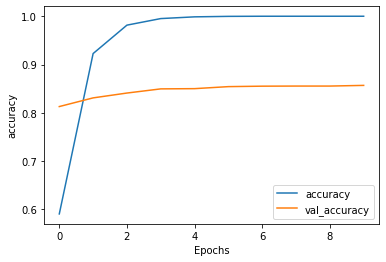

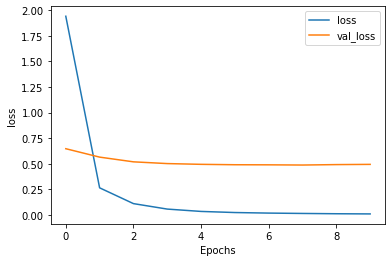

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 112kB 7.7MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2021-01-18 23:02:39.297081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [11]:
model.evaluate(test_ds.batch(64))

68/68 [==============================] - 13s 161ms/step - loss: 0.4592 - accuracy: 0.8697


[0.4591871201992035, 0.8696969747543335]

In [ ]:
!zip -r ./file.zip ./group1-*

  adding: group1-shard10of22.bin (deflated 7%)
  adding: group1-shard11of22.bin (deflated 7%)
  adding: group1-shard12of22.bin (deflated 7%)
  adding: group1-shard13of22.bin (deflated 7%)
  adding: group1-shard14of22.bin (deflated 7%)
  adding: group1-shard15of22.bin (deflated 7%)
  adding: group1-shard16of22.bin (deflated 7%)
  adding: group1-shard17of22.bin (deflated 7%)
  adding: group1-shard18of22.bin (deflated 7%)
  adding: group1-shard19of22.bin (deflated 7%)
  adding: group1-shard1of22.bin (deflated 7%)
  adding: group1-shard20of22.bin (deflated 7%)
  adding: group1-shard21of22.bin (deflated 8%)
  adding: group1-shard22of22.bin (deflated 8%)
  adding: group1-shard2of22.bin (deflated 7%)
  adding: group1-shard3of22.bin (deflated 7%)
  adding: group1-shard4of22.bin (deflated 7%)
  adding: group1-shard5of22.bin (deflated 7%)
  adding: group1-shard6of22.bin (deflated 7%)
  adding: group1-shard7of22.bin (deflated 7%)
  adding: group1-shard8of22.bin (deflated 7%)
  adding: group1-shar

In [ ]:
from google.colab import files
files.download("./file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Check the classification summary

In [12]:
import numpy as np
labels_test = []
labels_pred = []

for image,label in test_ds:
  labels_test.append(label.numpy())
  labels_pred.append(tf.argmax(model.predict(tf.expand_dims(image, axis=0)),axis=1).numpy())

In [13]:
labels_test[:10]

[40, 100, 90, 75, 84, 9, 16, 115, 0, 66]

In [15]:
labels_pred[:10]

[array([40]),
 array([100]),
 array([90]),
 array([75]),
 array([84]),
 array([9]),
 array([16]),
 array([115]),
 array([0]),
 array([66])]

In [16]:
from sklearn.metrics import recall_score, classification_report
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75        27
           1       0.92      0.92      0.92        39
           2       0.91      0.89      0.90        80
           3       0.93      0.81      0.86        31
           4       0.88      0.88      0.88        49
           5       0.90      0.94      0.92        49
           6       0.95      0.93      0.94        45
           7       0.84      0.91      0.88        35
           8       0.89      0.71      0.79        34
           9       1.00      0.97      0.99        73
          10       0.93      0.97      0.95        38
          11       0.77      0.82      0.80        40
          12       0.97      0.92      0.95        39
          13       0.93      0.85      0.89        33
          14       0.84      0.90      0.87        29
          15       0.58      0.68      0.62        22
          16       0.75      0.62      0.68        29
          17       0.81    

One can also get an idea of how the classifier does from the confusion matrix. Its hard to really visualize it here since we have 120 classes, but just to get an idea if some classes have performed better than the others.

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

# Use the model to predict the values from the validation dataset.

# Calculate the confusion matrix.
cm = confusion_matrix(labels_test, labels_pred)
# Log the confusion matrix as an image summary.

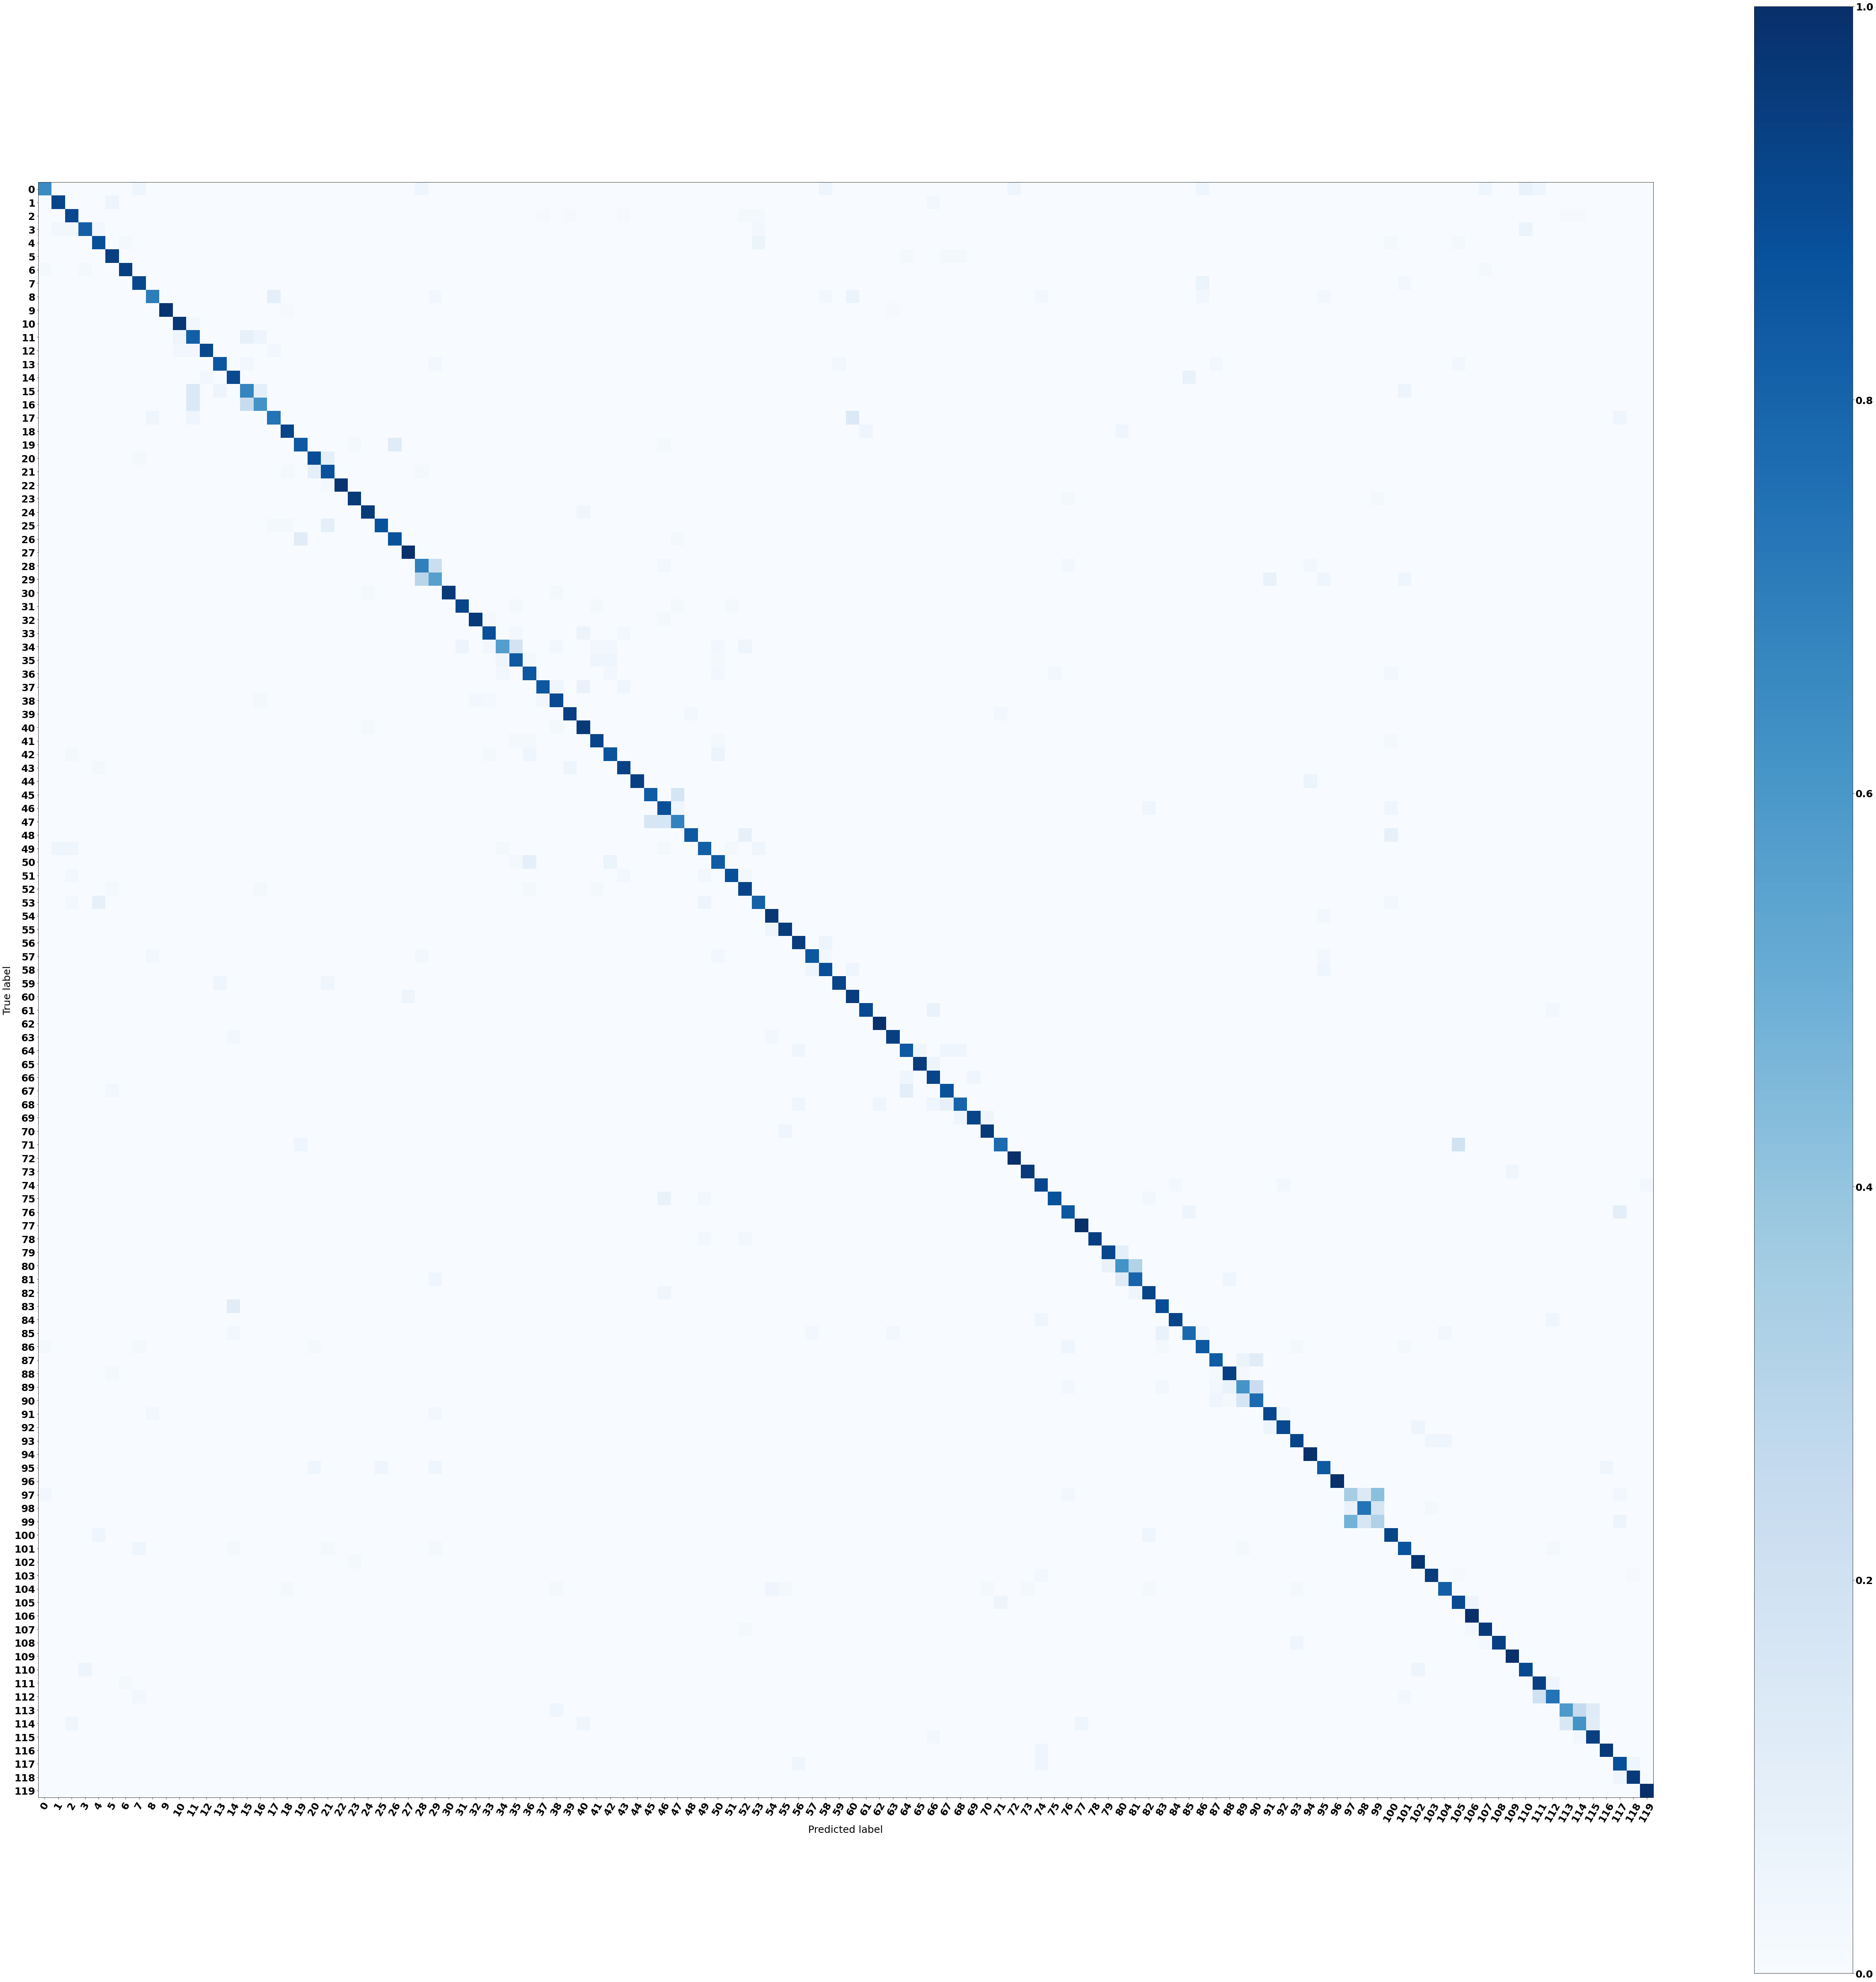

In [30]:
import matplotlib as mtpl
import matplotlib.pyplot as plt

font = {'weight' : 'bold',
        'size'   : 25}

mtpl.rc('font', **font)

figure = plt.figure(figsize=(90, 90))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(120)
plt.xticks(tick_marks, tick_marks, rotation = 60)
plt.yticks(tick_marks, tick_marks)

# Normalize the confusion matrix.
cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

# Use white text if squares are dark; otherwise black.
# threshold = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#   color = "white" if cm[i, j] > threshold else "black"
#   plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()